In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb
from skimage.io import imshow

import keras
from keras import losses
from keras.layers import Conv2D, UpSampling2D, MaxPool2D
from keras import layers, regularizers, optimizers, models, metrics, callbacks
from keras.datasets import cifar10
from keras.models import Model, Sequential
import pickle
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exercise 1: Convolutional Auto-encoder to reconstruct color images from identical color images

## Exercise 1.1
Importing the cifar10 dataset, we see that the data comprises of 60000 total images of 32 x 32 pixels and three channels (R - Red, G - Green , B - Blue) present in two sets which are train and validation set of 50000 and 10000 images respectively. We want a different breakup and have to split the dataset into training set (80% or 48000 images), validation set (10% or 6000 images) and test set (10% or 6000 images). The dataset is thus split into three parts: training, test, validation set in the ratio of 80: 10: 10 as instructed. The data was further normalized by dividing the pixel intensity values by a normalizing constant of 255, so that the input values will range between 0 and 1.

## Exercise 1.2
To implement a convolutional autoencoder, we have used the Keras and matplotlib libraries in python.  Four base models have been designed such that, the first model has the architecture prescribed for the assignment, the second model is curated by eliminating one Max - Pooling and 1 Up- Sampling layer from the first model. The third model is designed by using two separate filter sizes with a small - kernel filter in the encoding layer and a bigger kernel filter in the latent space and decoding layer. Fourth and last base model has been curated by removing a max-pooling and up-sampling layer in a similar manner from the third model. All the models were earlier trained for 10 epochs but later after observing that there is much scope for learning even after 10 epochs given the default learning rate of 1e-3 of Adam optimiser from keras, it was decided to implement learning rate reduction on Plateau feature, and Early stopping with best weights restoration feature of keras while running each of the base models for 100 Epochs. As displayed in the plot, even though the loss decreases quite steeply until epoch 10 it is still evident that it does not completely plateau out and this justifies running the model for higher number of epochs.

### Concept behind reducing the max - pooling and Up - sampling layers:
A maxpooling layer is used as a lossy operation of the network, to downsize the image to latent space representation. When a max-pooling layer is excluded, the compression of the latent space is not as it would have been had the max-pooling layer not been excluded. Likewise, a layer was excluded in the network while upsampling the image. Effectively by removing one max-pooling and one up-sampling layers, the latent space representation remains higher and the model does not lose out on important features and is able to retain a greater number of features in the latent space and hence while reconstructing it back. The model is thus able to reconstruct the image better and this can be observed from the reduced loss function. Although the increased latent space representation reduces the error, it could be prone to overfitting – which is an important aspect to be considered.

In [ ]:
# Loading CIFAR-10 dataset
(trainX, trainY), (testX, testY) = cifar10.load_data()

In [ ]:
X = np.concatenate((trainX,testX))
y = np.concatenate((trainY,testY))
print(np.shape(X),np.shape(y))
# print(y)
# Splitting data into training (80%), validation (10%) and test (10%) set
random_seed = np.random.randint(1,100)
trainX, testX, trainY, testY = train_test_split(X, y, test_size=0.2, random_state=random_seed, shuffle=True)
testX, valX, testY, valY = train_test_split(testX, testY, test_size=0.5, random_state=random_seed, shuffle=True)

(60000, 32, 32, 3) (60000, 1)
[[6]
 [9]
 [9]
 ...
 [5]
 [1]
 [7]]


In [ ]:
# Normalization of data
trainX = trainX.astype('float32') / 255
testX = testX.astype('float32') / 255
valX = valX.astype('float32') / 255

In [ ]:
# Hyperparameters - Part 1
img_shape = trainX.shape[1:]
kernel_size = 3
stride = 1
padding = 'same'
kernel_size_1 = 3
kernel_size_2 = 5

In [ ]:
def model1(img_shape, kernel_size, stride, padding):
  keras.backend.clear_session()
  model = Sequential(name="model1")

  # encoder
  model.add(Conv2D(8, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu', input_shape=img_shape))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(12, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  #latent space representation
  model.add(Conv2D(16, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
  #decoder
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2D(12, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2D(3, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
  model.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
  model.summary()
  return model

def model2(img_shape, kernel_size, stride, padding):
  keras.backend.clear_session()
  model = Sequential(name="model2")
  # encoder
  model.add(Conv2D(8, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu', input_shape=img_shape))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(12, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
  #latent space representation
  model.add(Conv2D(16, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
  #decoder
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2D(12, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
  model.add(Conv2D(3, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
  model.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
  model.summary()
  return model

def model3(img_shape, kernel_size_1, kernel_size_2, stride, padding):
  keras.backend.clear_session()
  model = Sequential(name="model3")

  # encoder
  model.add(Conv2D(8, kernel_size=kernel_size_1, strides=stride, padding=padding, activation='relu', input_shape=img_shape))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(12, kernel_size=kernel_size_1, strides=stride, padding=padding, activation='relu'))
  model.add(MaxPool2D(pool_size=(2,2)))
  #latent space representation
  model.add(Conv2D(16, kernel_size=kernel_size_2, strides=stride, padding=padding, activation='relu'))
  #decoder
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2D(12, kernel_size=kernel_size_2, strides=stride, padding=padding, activation='relu'))
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2D(3, kernel_size=kernel_size_2, strides=stride, padding=padding, activation='relu'))
  model.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
  model.summary()
  return model

def model4(img_shape, kernel_size_1, kernel_size_2, stride, padding):
  keras.backend.clear_session()
  model = Sequential(name="model4")

  # encoder
  model.add(Conv2D(8, kernel_size=kernel_size_1, strides=stride, padding=padding, activation='relu', input_shape=img_shape))
  model.add(MaxPool2D(pool_size=(2,2)))
  model.add(Conv2D(12, kernel_size=kernel_size_1, strides=stride, padding=padding, activation='relu'))
  #latent space representation
  model.add(Conv2D(16, kernel_size=kernel_size_2, strides=stride, padding=padding, activation='relu'))
  #decoder
  model.add(UpSampling2D(size=(2,2)))
  model.add(Conv2D(12, kernel_size=kernel_size_2, strides=stride, padding=padding, activation='relu'))
  model.add(Conv2D(3, kernel_size=kernel_size_2, strides=stride, padding=padding, activation='relu'))
  model.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
  model.summary()
  return model

In [ ]:
def model_fit(model, train, val,epochs,LrReduce_and_EarlyStopping):
  if (LrReduce_and_EarlyStopping):
      callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1, restore_best_weights = True)
      lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00005)
      history = model.fit(train, train,  callbacks=[lr_reduce, callback], epochs=epochs, validation_data=(val, val))
  else:
      history = model.fit(train, train,  epochs=10, validation_data=(val, val))
  return history

In [ ]:
def plot_OriginalVsPredicted_Testset(test, predicted):
  plt.figure(figsize=(20, 4))
  for image in range(10):
    # display original
    ax = plt.subplot(2, 10, image + 1)
    plt.imshow(test[image])
    plt.title("Original Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, 10, image + 1 + 10)
    plt.imshow(predicted[image])
    plt.title("Reconstructed Image")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

In [ ]:
def plot_AccuracyAndLoss_vsEpochs(history):
  fig, axs = plt.subplots(1,2,figsize=(15,5)) 
  # summarize history for accuracy
  axs[0].plot(history.history['accuracy']) 
  axs[0].plot(history.history['val_accuracy']) 
  axs[0].set_title('Model Accuracy')
  axs[0].set_ylabel('Accuracy') 
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'validate'], loc='upper left')
  # summarize history for loss
  axs[1].plot(history.history['loss']) 
  axs[1].plot(history.history['val_loss']) 
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss') 
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'validate'], loc='upper right')
  plt.show()

def plot_AccuracyAndLoss_vsEpochs_from_loaded_model(history):
  fig, axs = plt.subplots(1,2,figsize=(15,5)) 
  # summarize history for accuracy
  axs[0].plot(history['accuracy']) 
  axs[0].plot(history['val_accuracy']) 
  axs[0].set_title('Model Accuracy')
  axs[0].set_ylabel('Accuracy') 
  axs[0].set_xlabel('Epoch')
  axs[0].legend(['train', 'validate'], loc='upper left')
  # summarize history for loss
  axs[1].plot(history['loss']) 
  axs[1].plot(history['val_loss']) 
  axs[1].set_title('Model Loss')
  axs[1].set_ylabel('Loss') 
  axs[1].set_xlabel('Epoch')
  axs[1].legend(['train', 'validate'], loc='upper right')
  plt.show()

Model: "model1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          1744      
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 16)       0    

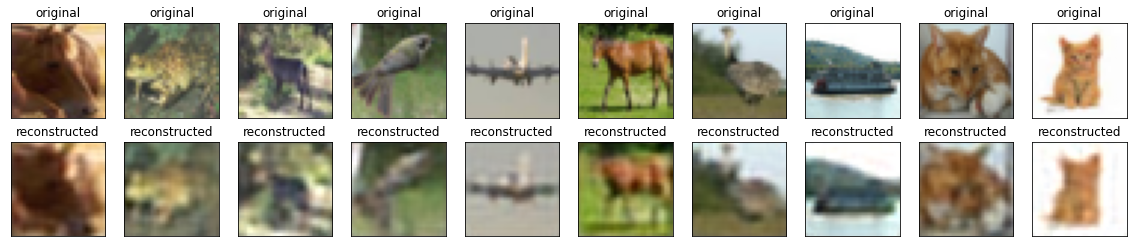


Plotting the metrics: 


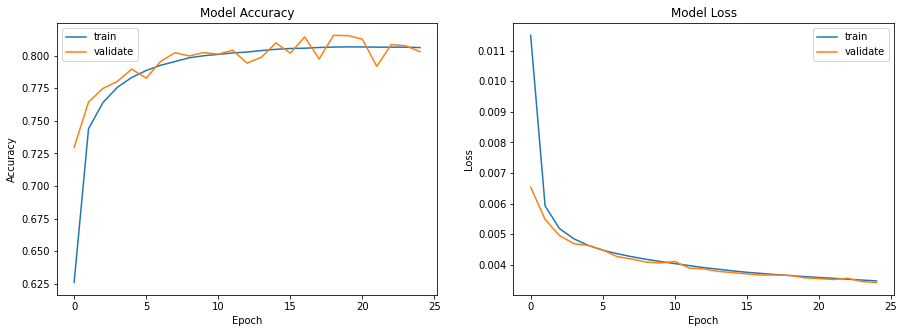


Test Data Evaluation: 
188/188 [==============================] - 1s 3ms/step - loss: 0.0037 - accuracy: 0.8124


In [ ]:
model = model1(img_shape, kernel_size, stride, padding)
enhance_Training = True
print("\nTraining the Model: ")
history = model_fit(model, trainX, valX, 100, enhance_Training )
print("\nPrediction on Test data: ")
predicted = model.predict(testX)
print("\nPlotting the predictions: ")
plot_OriginalVsPredicted_Testset(testX, predicted)
print("\nPlotting the metrics: ")
plot_AccuracyAndLoss_vsEpochs(history)
print("\nTest Data Evaluation: ")
test_loss, test_acc = model.evaluate(testX, testX)

Model: "model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        1744      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 12)        1740 

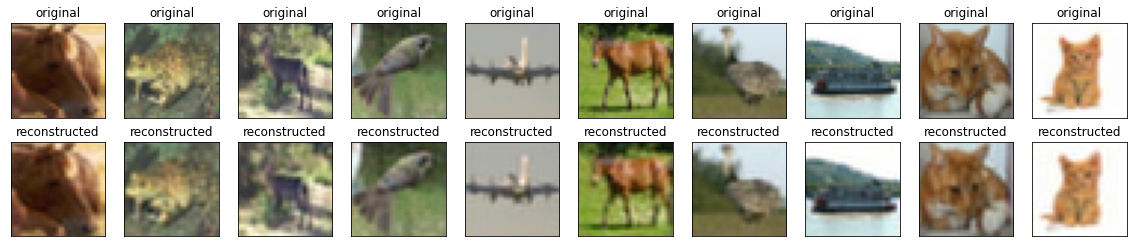


Plotting the metrics: 


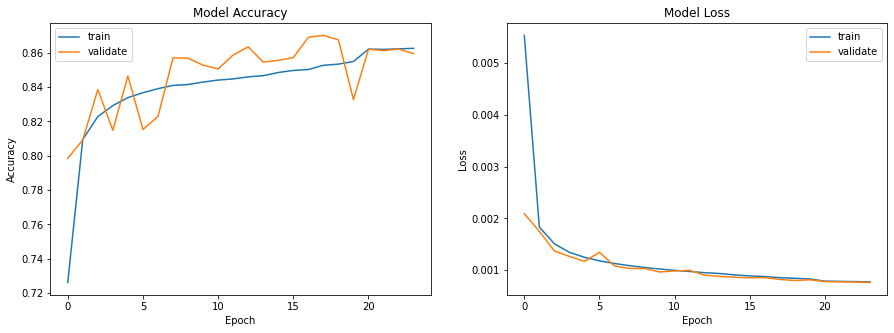


Test Data Evaluation: 
188/188 [==============================] - 1s 3ms/step - loss: 8.3138e-04 - accuracy: 0.8676


In [ ]:
model = model2(img_shape, kernel_size, stride, padding)
enhance_Training = True
print("\nTraining the Model: ")
history = model_fit(model, trainX, valX,100, enhance_Training )
print("\nPrediction on Test data: ")
predicted = model.predict(testX)
print("\nPlotting the predictions: ")
plot_OriginalVsPredicted_Testset(testX, predicted)
print("\nPlotting the metrics: ")
plot_AccuracyAndLoss_vsEpochs(history)
print("\nTest Data Evaluation: ")
test_loss, test_acc = model.evaluate(testX, testX)

Model: "model3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 16)          4816      
                                                                 
 up_sampling2d (UpSampling2D  (None, 16, 16, 16)       0    


Plotting the predictions: 


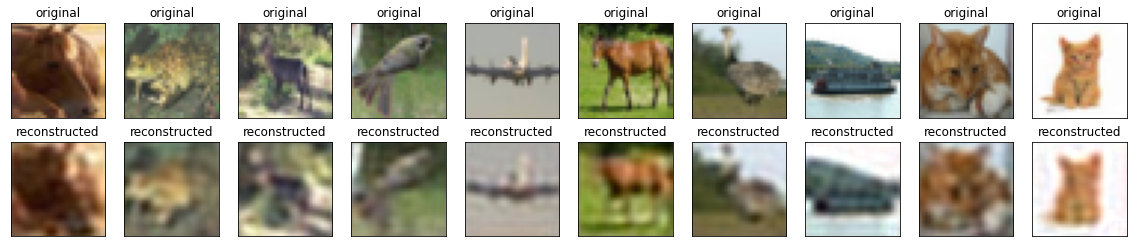


Plotting the metrics: 


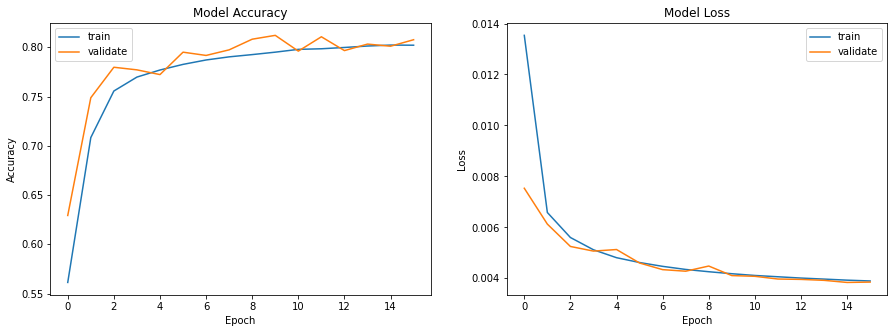


Test Data Evaluation: 
188/188 [==============================] - 1s 3ms/step - loss: 0.0041 - accuracy: 0.8097


In [ ]:
model = model3(img_shape, kernel_size_1, kernel_size_2, stride, padding)
enhance_Training = True
print("\nTraining the Model: ")
history = model_fit(model, trainX, valX,100, enhance_Training )
print("\nPrediction on Test data: ")
predicted = model.predict(testX)
print("\nPlotting the predictions: ")
plot_OriginalVsPredicted_Testset(testX, predicted)
print("\nPlotting the metrics: ")
plot_AccuracyAndLoss_vsEpochs(history)
print("\nTest Data Evaluation: ")
test_loss, test_acc = model.evaluate(testX, testX)

Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        4816      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 12)        4812 

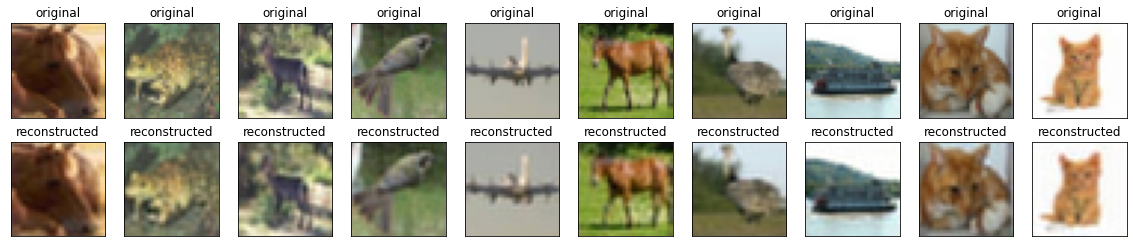


Plotting the metrics: 


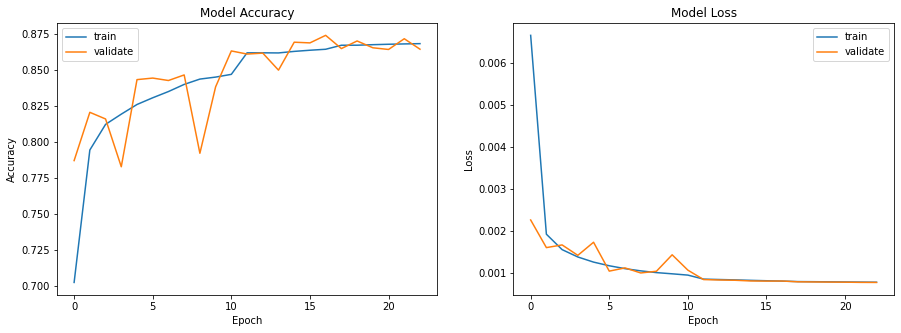


Test Data Evaluation: 
188/188 [==============================] - 1s 4ms/step - loss: 8.1520e-04 - accuracy: 0.8721


In [ ]:
model = model4(img_shape, kernel_size_1, kernel_size_2, stride, padding)
enhance_Training = True
print("\nTraining the Model: ")
history = model_fit(model, trainX, valX, 100, enhance_Training )
print("\nPrediction on Test data: ")
predicted = model.predict(testX)
print("\nPlotting the predictions: ")
plot_OriginalVsPredicted_Testset(testX, predicted)
print("\nPlotting the metrics: ")
plot_AccuracyAndLoss_vsEpochs(history)
print("\nTest Data Evaluation: ")
test_loss, test_acc = model.evaluate(testX, testX)

In [ ]:
# Saved Model --- 

In [ ]:
# import pickle
# model_name = "model4"
# print(model.name)
# # Save the trained model
# model.save('/content/drive/MyDrive/Colab_Models/Acml_Models/{}'.format(model_name))
# # Dump the history object as dictionary
# with open('/content/drive/MyDrive/Colab_Models/Acml_Models/{}/{}_history.pkl'.format(model_name, model_name), 'wb') as f:
#     pickle.dump(history.history, f)
# model = keras.models.load_model('/content/drive/MyDrive/Colab_Models/Acml_Models/model4')
# print('Model: ',model.name)
# # Load history
# history = pickle.load(open('/content/drive/MyDrive/Colab_Models/Acml_Models/{}/{}_history.pkl'.format('model4','model4'),'rb'))

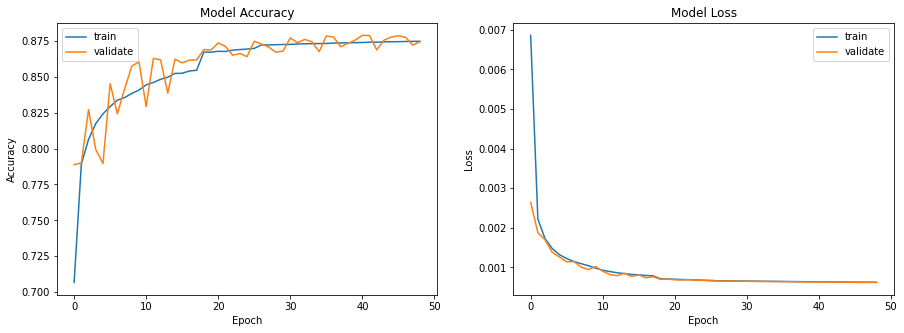

In [ ]:
plot_AccuracyAndLoss_vsEpochs_from_loaded_model(history)

In [ ]:
test_loss, test_acc = model.evaluate(testX, testX)

188/188 [==============================] - 1s 4ms/step - loss: 6.3462e-04 - accuracy: 0.8769


## Exercise 2: Running different experiments with the hyper - parameters to curate a good model architecture for auto - encoder

### Exercise 2.1 - 
Question: What is the size of the latent space representation of the above network?

The latent space of the first base model, i.e. model1 has been calculated as below:

〖latent space=((W-K+2P)/S+1)〗^2*C

Values of individual terms: 
W = Input volume = 8 (8 is because of applying two max-pooling layers on 32 x 32 pixel images)

K = Kernel size = 3

P = Padding = 1, S = Stride = 1, C = Channels = 16

Thus, size of latent space = ((8-3+2 * 1)/1+1)^2*16 =  1024

### Exercise 2.2
It was observed from the results that the model4 was the best base model and thus, this model was used as a candidate for experimenting with the filter sizes and strides. A total of 9 configurations were created from the experiments and each of the 9 models were the trained and evaluated to check which configuration performs the best. The 9 configurations are as below:
Experiment 1. Filter sizes 1 and 3, Stride 1
Experiment 2. Filter sizes 1 and 3, Stride 2
Experiment 3. Filter sizes 1 and 3, Stride 3
Experiment 4. Filter sizes 3 and 5, Stride 1
Experiment 5. Filter sizes 3 and 5, Stride 2
Experiment 6. Filter sizes 3 and 5, Stride 3
Experiment 7. Filter sizes 5 and 7, Stride 1
Experiment 8. Filter sizes 5 and 7, Stride 2
Experiment 9. Filter sizes 5 and 7, Stride 3

Note that the padding was always maintained as "same". The model from experiment 9 gave the best results with a test set accuracy above 90% as listed below.

In [ ]:
# Hyperparameters - Part 2
kernel_sizes = [1,3,5]
strides = [1,2,3]

Kernel Size 1: 1, Kernel Size 2: 3, Stride: 1, Padding: same
Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        108       
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        1744      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 

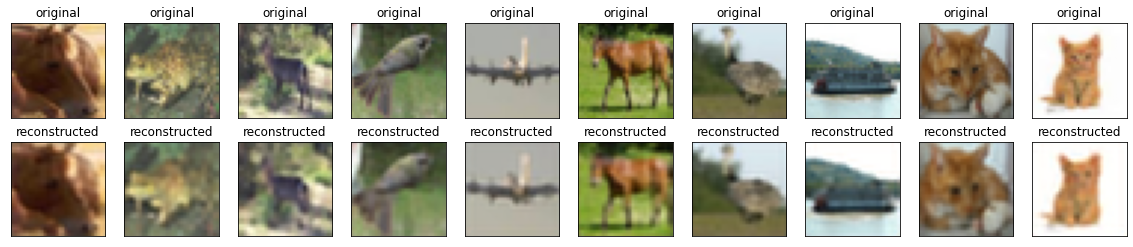



188/188 [==============================] - 1s 3ms/step - loss: 0.0019 - accuracy: 0.9053

Kernel Size 1: 1, Kernel Size 2: 3, Stride: 2, Padding: same
Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 8)         32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 12)          108       
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 16)          1744      
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 16)         0         
 )                                     

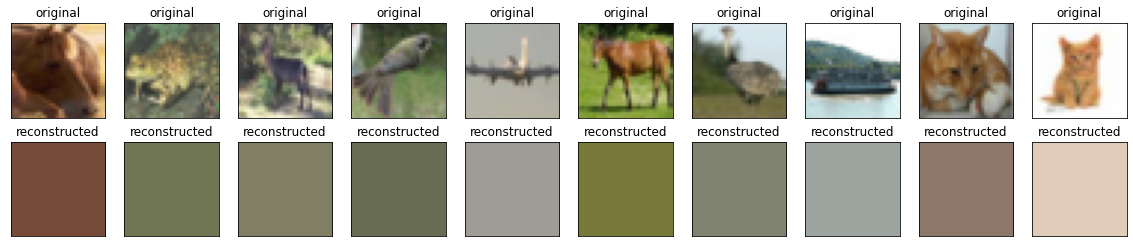



188/188 [==============================] - 1s 3ms/step - loss: 0.0450 - accuracy: 0.6742

Kernel Size 1: 1, Kernel Size 2: 3, Stride: 3, Padding: same
Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 11, 8)         32        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 12)          108       
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 16)          1744      
                                                                 
 up_sampling2d (UpSampling2D  (None, 2, 2, 16)         0         
 )                                     

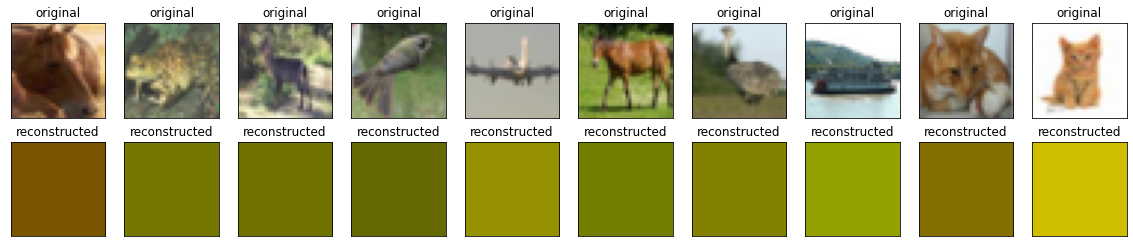



188/188 [==============================] - 1s 3ms/step - loss: 0.1210 - accuracy: 0.5467

Kernel Size 1: 3, Kernel Size 2: 5, Stride: 1, Padding: same
Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        876       
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        4816      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 16)       0         
 )                                     

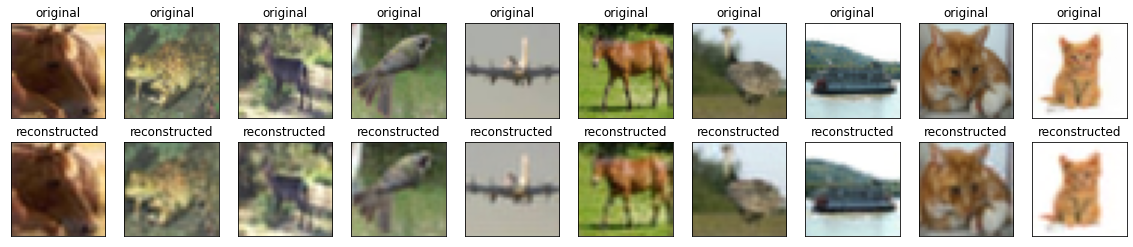



188/188 [==============================] - 1s 4ms/step - loss: 9.9125e-04 - accuracy: 0.8709

Kernel Size 1: 3, Kernel Size 2: 5, Stride: 2, Padding: same
Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 12)          876       
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 16)          4816      
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 16)         0         
 )                                 

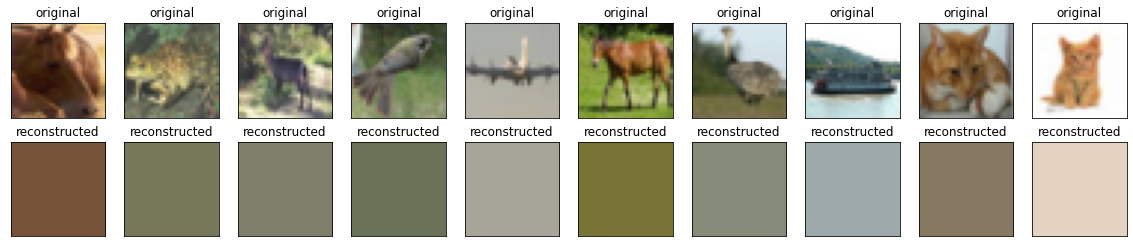



188/188 [==============================] - 1s 4ms/step - loss: 0.0443 - accuracy: 0.6794

Kernel Size 1: 3, Kernel Size 2: 5, Stride: 3, Padding: same
Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 11, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 12)          876       
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 16)          4816      
                                                                 
 up_sampling2d (UpSampling2D  (None, 2, 2, 16)         0         
 )                                     

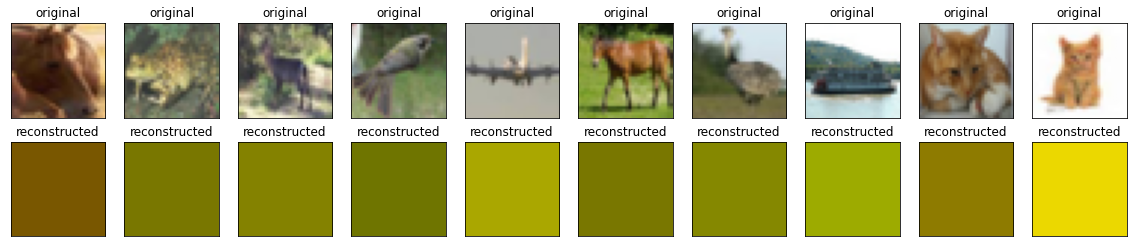



188/188 [==============================] - 1s 4ms/step - loss: 0.1189 - accuracy: 0.5574

Kernel Size 1: 5, Kernel Size 2: 7, Stride: 1, Padding: same
Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 12)        2412      
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 16)        9424      
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 16)       0         
 )                                     

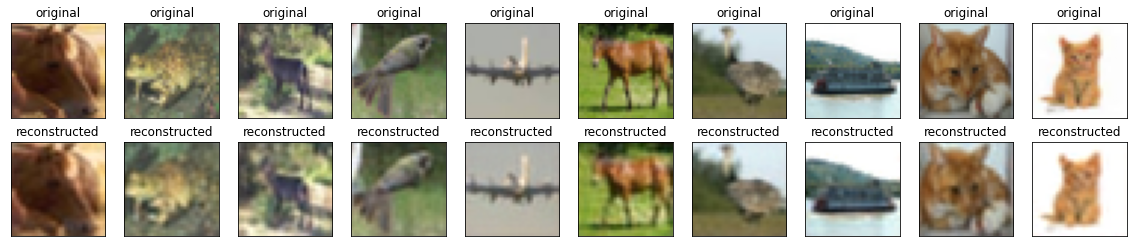



188/188 [==============================] - 1s 5ms/step - loss: 0.0013 - accuracy: 0.8542

Kernel Size 1: 5, Kernel Size 2: 7, Stride: 2, Padding: same
Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 8)         608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 12)          2412      
                                                                 
 conv2d_2 (Conv2D)           (None, 2, 2, 16)          9424      
                                                                 
 up_sampling2d (UpSampling2D  (None, 4, 4, 16)         0         
 )                                     

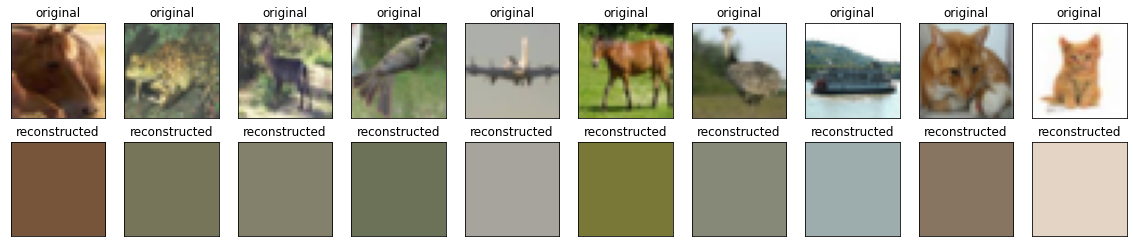



188/188 [==============================] - 1s 4ms/step - loss: 0.0442 - accuracy: 0.6864

Kernel Size 1: 5, Kernel Size 2: 7, Stride: 3, Padding: same
Model: "model4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 11, 11, 8)         608       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 8)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 2, 12)          2412      
                                                                 
 conv2d_2 (Conv2D)           (None, 1, 1, 16)          9424      
                                                                 
 up_sampling2d (UpSampling2D  (None, 2, 2, 16)         0         
 )                                     

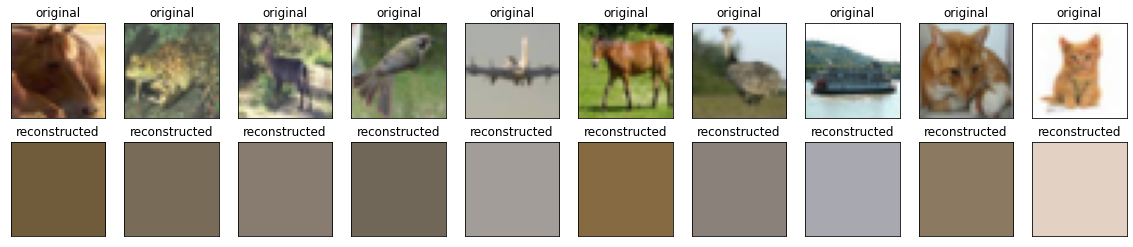



188/188 [==============================] - 1s 4ms/step - loss: 0.0448 - accuracy: 0.6275

Ran 9 Experiments.
Experiment 1: Test Loss = 0.0018797030206769705 and Test accuracy = 0.9053173661231995
Experiment 2: Test Loss = 0.045049142092466354 and Test accuracy = 0.6742244362831116
Experiment 3: Test Loss = 0.12104669213294983 and Test accuracy = 0.5466700792312622
Experiment 4: Test Loss = 0.0009912500390782952 and Test accuracy = 0.8709431886672974
Experiment 5: Test Loss = 0.04425084963440895 and Test accuracy = 0.6794365048408508
Experiment 6: Test Loss = 0.11889611929655075 and Test accuracy = 0.5573572516441345
Experiment 7: Test Loss = 0.0013005342334508896 and Test accuracy = 0.8541803359985352
Experiment 8: Test Loss = 0.04419732838869095 and Test accuracy = 0.6863738894462585
Experiment 9: Test Loss = 0.04476483538746834 and Test accuracy = 0.6275256872177124
Best Model: Model1


In [ ]:
histories = []
test_losss = []
test_accuracy = []
count = 0
for size in kernel_sizes:
    for step in strides:
        count+=1
        modelnumber = count
        print("Kernel Size 1: " + str(size) + ", Kernel Size 2: "+str(size+2)+", Stride: " + str(step)  + ", Padding: " + padding)
        model = model4(img_shape, size, size+2, step, padding)
        print()
        history = model_fit(model, trainX, valX,60, LrReduce_and_EarlyStopping=True )
        print()
        predicted = model.predict(testX)
        plot_OriginalVsPredicted_Testset(testX, predicted)
        print()
        histories.append(history)
        print()
        test_loss, test_acc = model.evaluate(testX, testX)
        test_losss.append(test_loss)
        test_accuracy.append(test_acc)
        print()
print('Ran '+str(count)+' Experiments.')
for i in range(count):
    print('Experiment '+str(i+1)+': Test Loss = '+str(test_losss[i])+' and Test accuracy = '+str(test_accuracy[i]))
print('Best Model: Model'+str(np.argmax(test_accuracy)+1))

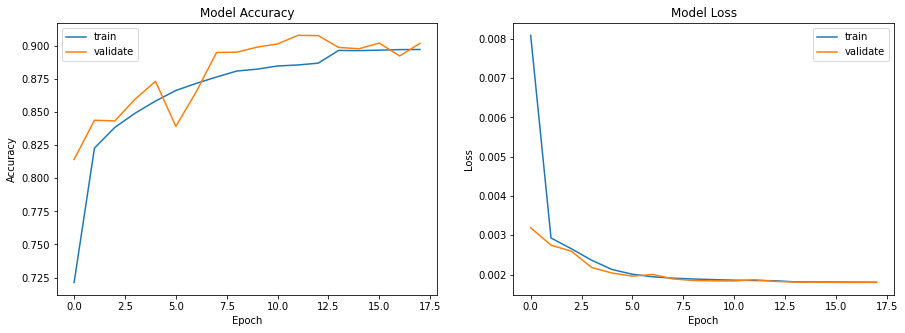

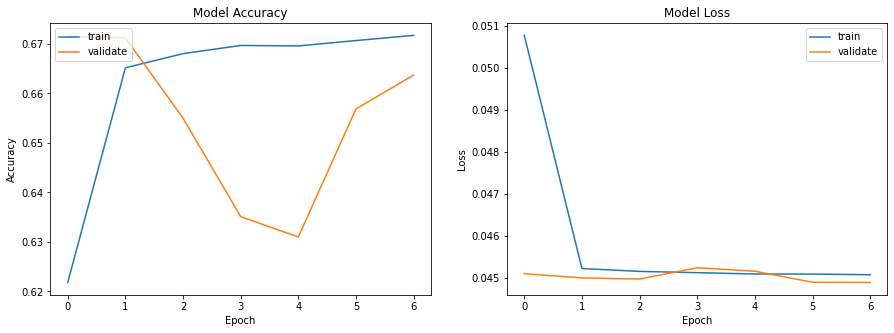

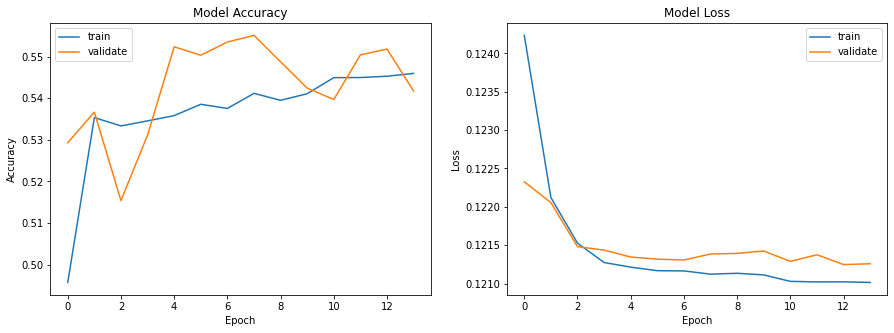

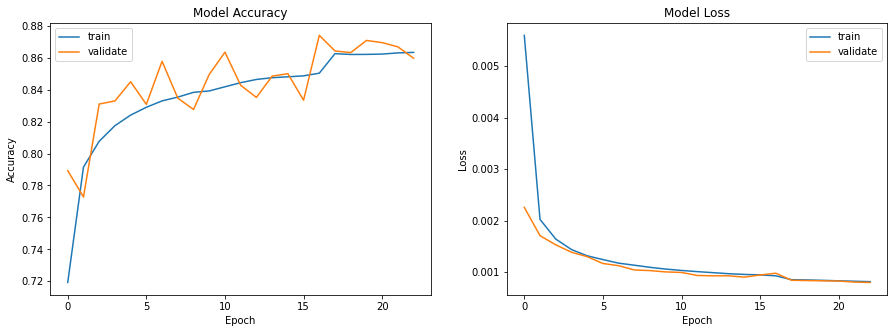

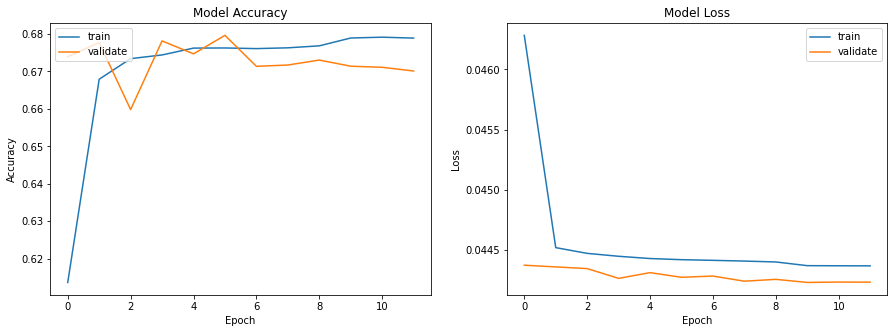

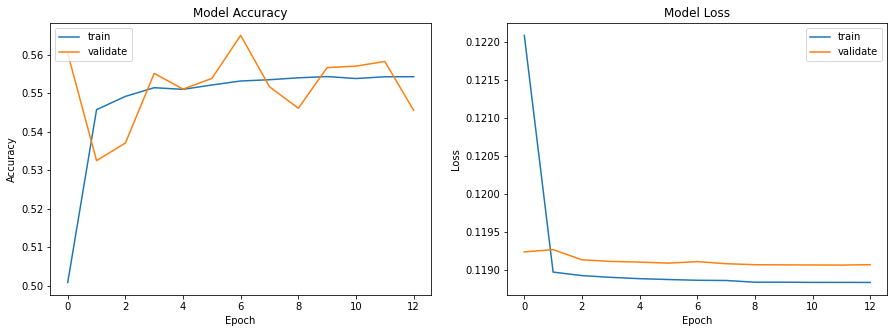

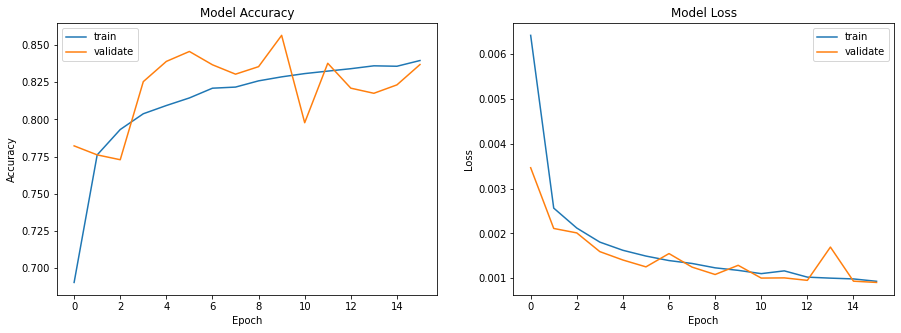

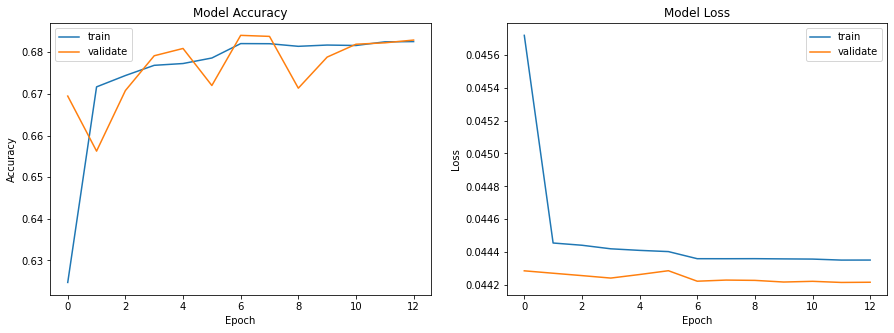

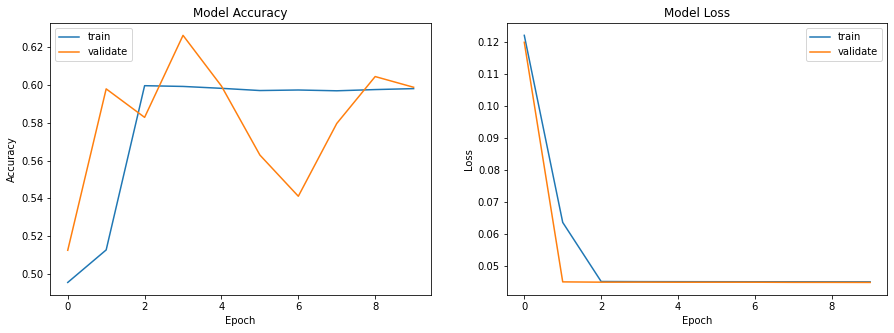

In [ ]:
for i in histories:
  print()
  plot_AccuracyAndLoss_vsEpochs(i)
  print()

Initially, when the kernel sizes were varied starting from kernel size of ‘1‘ up to kernel size of ‘5’. It is observed that the reconstruction error increases with increase in the kernel size, with not much of difference between kernel size of ‘3’ and ‘5’. But post the kernel size of 5, the error starts to increase, and this configuration was thus excluded from the listed experimental models. This could be due to higher kernel sizes not being able to pick up on the smaller features from the images. Upon observing, we also realised that the strides of 2 and 3 gave absurd reconstructions of the input images, with the jump in the stride of the convolutions causing the model to only emphasize on the majorly abundant color in the background of the image to be learned thereby producing a solid colored image at the output while missing on all the contours and features of the input image.

## Exercise 3: Learning Colorization of Gray scale images

### Exercise 3.1
Here, the network has been modified to reconstruct colors in all RGB channels despite the network being fed with a grayscale image. To run this part of the experiment, the hyperparameters that was chosen were kernel size'1' and '3' and the stride as '1' which yielded the best performance in previous section.

The colorization scheme used takes place in two steps: 


*   The image is first converted to a LAB space where it contains a luminance component and a chrominance component. The luminance reprensents the intensity information of the image whereas, the chrominance conveys the "color" information of the picture.
*   The modified network now has an input of a single channel image where the luminance is passed as the input to reconstruct colors in the image based on the chrominance part which is the output of the network.



In [ ]:
trainLuminance = []
trainChrominance = []
for i in trainX:
    #print(i)
    lab = rgb2lab(i)
    trainLuminance.append(lab[:,:,0])
    trainChrominance.append(lab[:,:,1:] / 128)

In [ ]:
valLuminance = []
valChrominance = []
for i in valX:
  lab = rgb2lab(i)
  valLuminance.append(lab[:,:,0])
  valChrominance.append(lab[:,:,1:] / 128)

In [ ]:
trainLuminance = np.array(trainLuminance)
trainChrominance = np.array(trainChrominance)

valLuminance = np.array(valLuminance)
valChrominance = np.array(valChrominance)

trainLuminance = trainLuminance.reshape(trainLuminance.shape+(1,))
valLuminance = valLuminance.reshape(valLuminance.shape+(1,))

In [ ]:
kernel_size_1_bw = 1
kernel_size_2_bw = 3

model_bw = Sequential()
# encoder
model_bw.add(Conv2D(8, kernel_size=kernel_size_1_bw, strides=stride, padding=padding, activation='relu', input_shape=(32,32,1)))
model_bw.add(MaxPool2D(pool_size=(2,2)))
model_bw.add(Conv2D(12, kernel_size=kernel_size_1_bw, strides=stride, padding=padding, activation='relu'))
#latent space representation
model_bw.add(Conv2D(16, kernel_size=kernel_size_2_bw, strides=stride, padding=padding, activation='relu'))
#decoder
model_bw.add(UpSampling2D(size=(2,2)))
model_bw.add(Conv2D(12, kernel_size=kernel_size_2_bw, strides=stride, padding=padding, activation='relu'))
model_bw.add(Conv2D(2, kernel_size=kernel_size_2_bw, strides=stride, padding=padding, activation='tanh'))


model_bw.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
model_bw.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 32, 32, 8)         16        
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 12)        108       
                                                                 
 conv2d_22 (Conv2D)          (None, 16, 16, 16)        1744      
                                                                 
 up_sampling2d_5 (UpSampling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_23 (Conv2D)          (None, 32, 32, 12)       

In [ ]:
callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1, restore_best_weights = True)
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00005)      
history_color = model_bw.fit(trainLuminance, trainChrominance, callbacks=[lr_reduce, callback], epochs=100, validation_data=(valLuminance, valChrominance))

Epoch 1/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0226 - accuracy: 0.5880 - val_loss: 0.0108 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 2/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0109 - accuracy: 0.6208 - val_loss: 0.0105 - val_accuracy: 0.6262 - lr: 0.0010
Epoch 3/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0108 - accuracy: 0.6244 - val_loss: 0.0105 - val_accuracy: 0.6319 - lr: 0.0010
Epoch 4/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0108 - accuracy: 0.6248 - val_loss: 0.0103 - val_accuracy: 0.6311 - lr: 0.0010
Epoch 5/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0107 - accuracy: 0.6247 - val_loss: 0.0103 - val_accuracy: 0.6322 - lr: 0.0010
Epoch 6/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0107 - accuracy: 0.6249 - val_loss: 0.0102 - val_accuracy: 0.6306 - lr: 0.0010
Epoch 7/100
1500/1500 [=============================

In [ ]:
test_img = []
for i in testX:
  lab = rgb2lab(i)
  test_img.append(lab[:,:,0])

test_img = np.array(test_img)

test_img_passed = test_img.reshape(test_img.shape+(1,))

In [ ]:
output = model_bw.predict(test_img_passed)
output = output*128

188/188 [==============================] - 0s 2ms/step


In [ ]:
recolor_img = []
for i in range(0, 10):
  result = np.zeros((32,32,3))
  result[:,:,0] = test_img[i]#[:,:,0]
  result[:,:,1:] = output[i] 
  recolor_img.append(lab2rgb(result))

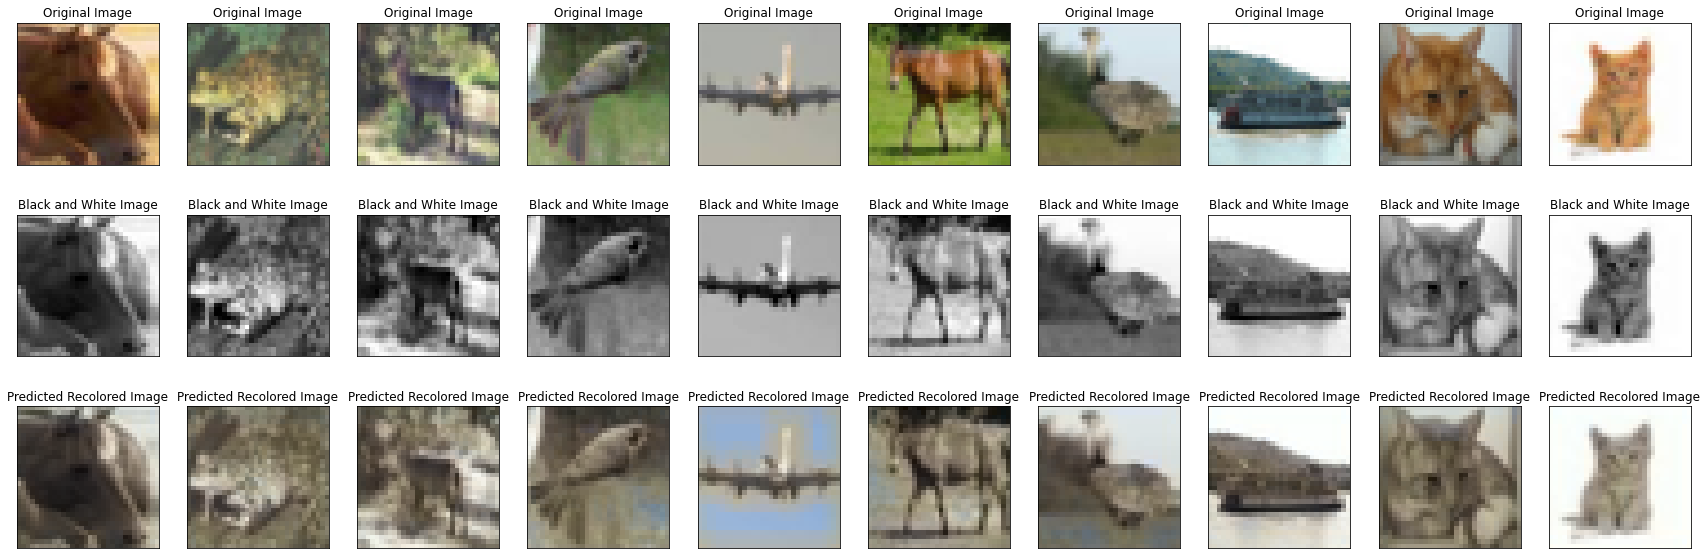

In [ ]:
plt.figure(figsize=(30, 10))
for i in range(10):
  # display original
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(testX[i])
  plt.title("Original Image")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

   # display B/W
  ax = plt.subplot(3, 10, i + 1 + 10)
  plt.imshow(test_img[i], cmap='gray')
  plt.title("Black and White Image")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display Re-coloured
  ax = plt.subplot(3, 10, i + 1 + 20)
  plt.imshow(recolor_img[i])
  plt.title("Predicted Recolored Image")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

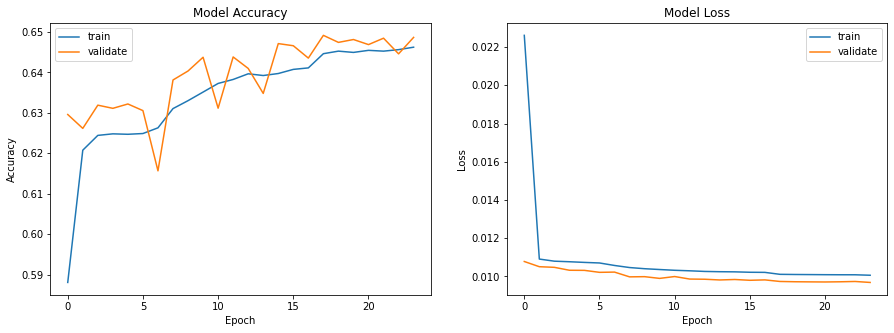

In [ ]:
plot_AccuracyAndLoss_vsEpochs(history_color)

### Exercise 3.2
#### PART A:
Experimenting with hyperparameters of colorizing model - Trying the performance with larger kernel sizes. 

The model used here uses both the kernel sizes as 3 in both, the encoder and the decoder. 

In [ ]:
kernel_size_1_bw = 3
kernel_size_2_bw = 3

model_bw = Sequential()
# encoder
model_bw.add(Conv2D(8, kernel_size=kernel_size_1_bw, strides=stride, padding=padding, activation='relu', input_shape=(32,32,1)))
model_bw.add(MaxPool2D(pool_size=(2,2)))
model_bw.add(Conv2D(12, kernel_size=kernel_size_1_bw, strides=stride, padding=padding, activation='relu'))
#latent space representation
model_bw.add(Conv2D(16, kernel_size=kernel_size_2_bw, strides=stride, padding=padding, activation='relu'))
#decoder
model_bw.add(UpSampling2D(size=(2,2)))
model_bw.add(Conv2D(12, kernel_size=kernel_size_2_bw, strides=stride, padding=padding, activation='relu'))
model_bw.add(Conv2D(2, kernel_size=kernel_size_2_bw, strides=stride, padding=padding, activation='tanh'))

model_bw.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
model_bw.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 32, 32, 8)         80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_26 (Conv2D)          (None, 16, 16, 12)        876       
                                                                 
 conv2d_27 (Conv2D)          (None, 16, 16, 16)        1744      
                                                                 
 up_sampling2d_6 (UpSampling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_28 (Conv2D)          (None, 32, 32, 12)       

In [ ]:
callback = callbacks.EarlyStopping(monitor='val_accuracy', patience=6, verbose=1, restore_best_weights = True)
lr_reduce = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, min_lr=0.00005)      
history_color = model_bw.fit(trainLuminance, trainChrominance, callbacks=[lr_reduce, callback], epochs=100, validation_data=(valLuminance, valChrominance))

Epoch 1/100
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0251 - accuracy: 0.6233 - val_loss: 0.0106 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 2/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0110 - accuracy: 0.6264 - val_loss: 0.0105 - val_accuracy: 0.6264 - lr: 0.0010
Epoch 3/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0109 - accuracy: 0.6261 - val_loss: 0.0104 - val_accuracy: 0.6307 - lr: 0.0010
Epoch 4/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0108 - accuracy: 0.6270 - val_loss: 0.0103 - val_accuracy: 0.6296 - lr: 0.0010
Epoch 5/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0108 - accuracy: 0.6270 - val_loss: 0.0103 - val_accuracy: 0.6304 - lr: 0.0010
Epoch 6/100
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0107 - accuracy: 0.6270 - val_loss: 0.0103 - val_accuracy: 0.6254 - lr: 0.0010
Epoch 7/100
1500/1500 [=============================

In [ ]:
test_img = []
for i in testX:
  lab = rgb2lab(i)
  test_img.append(lab[:,:,0])

test_img = np.array(test_img)

test_img_paased = test_img.reshape(test_img.shape+(1,))

In [ ]:
output = model_bw.predict(test_img_passed)
output = output*128

188/188 [==============================] - 0s 2ms/step


In [ ]:
recolor_img = []
for i in range(0, 10):
  result = np.zeros((32,32,3))
  result[:,:,0] = test_img[i]#[:,:,0]
  result[:,:,1:] = output[i]
  recolor_img.append(lab2rgb(result))

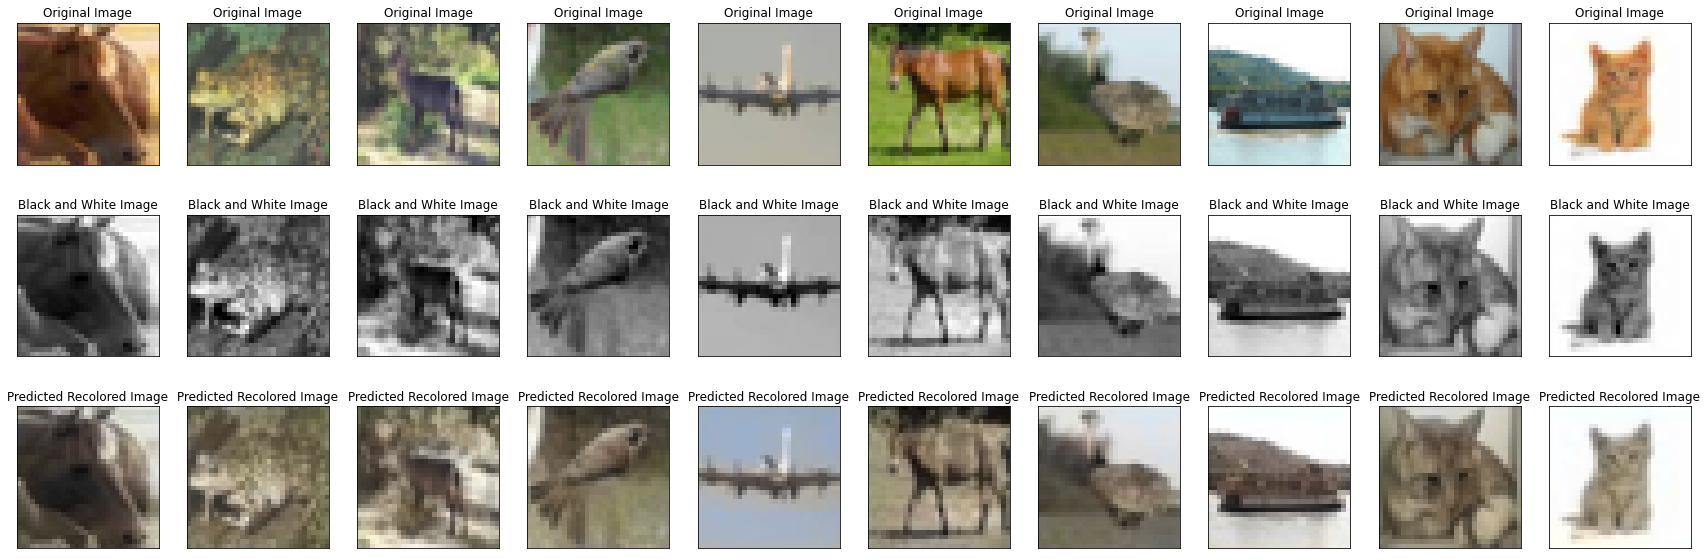

In [ ]:
plt.figure(figsize=(30, 10))
for i in range(10):
  # display original
  ax = plt.subplot(3, 10, i + 1)
  plt.imshow(testX[i])
  plt.title("Original Image")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

   # display B/W
  ax = plt.subplot(3, 10, i + 1 + 10)
  plt.imshow(test_img[i], cmap='gray')
  plt.title("Black and White Image")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display Re-coloured
  ax = plt.subplot(3, 10, i + 1 + 20)
  plt.imshow(recolor_img[i])
  plt.title("Predicted Recolored Image")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

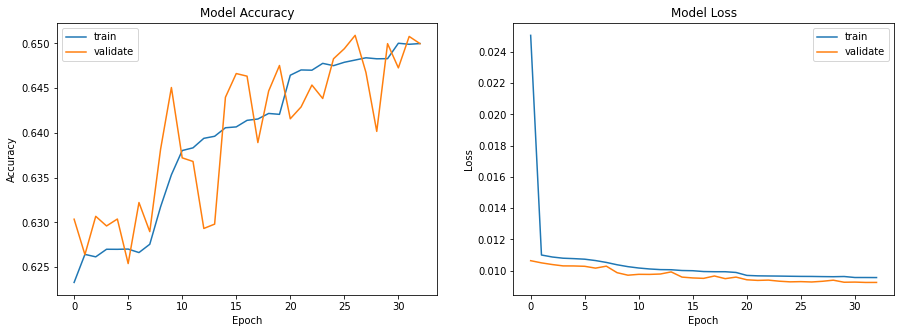

In [ ]:
plot_AccuracyAndLoss_vsEpochs(history_color)

## Exercise 3.2
**We also configured the network layers and ran this experiment. The reduced layer configuration did not yield any beneficial result as it did in Exercise 2.2. This could be due to the reason that the input image was a low-resolution grayscale image and hence not much features could be extracted by the network. 
Our model could not entirely predict the color of image correctly. This could be because the network could not detect/differentiate edges, contours, corners in the grayscale images and hence making it difficult to classify the images. As a future scope, the model could be experimented with increased kernel size and specific kernels like edge detection kernels, corner detection kernels. By doing so, the edges, contours, corners are enhanced, and the network might be able to better recognize & classify the image correctly. Also, a higher resolution of image could improve the resulting colorization result.**

#### PART B:
Experimenting with a different color space - GrayScale (Input)  and RGB (output) instead of Luminance (Input) and L A B space (Output). 

In the initial part of the colorization, the image was converted to a LAB space and the luminance component of the image is provided as the input and the model predicts the chrominance for that image. 

Here a different colorization scheme is used where the entire RGB image is prediced instead of just the chrominance.

In [ ]:
model = Sequential()
# encoder
model.add(Conv2D(8, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu', input_shape=(32,32,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(12, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

#latent space representation
model.add(Conv2D(16, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))

#decoder
model.add(UpSampling2D(size=(2,2)))
model.add(Conv2D(12, kernel_size=kernel_size, strides=stride, padding=padding, activation='relu'))
model.add(Conv2D(3, kernel_size=kernel_size, strides=stride, padding=padding, activation='tanh'))
model.add(UpSampling2D(size=(2,2)))

model.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 32, 32, 8)         80        
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_16 (Conv2D)          (None, 16, 16, 12)        876       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 12)         0         
 2D)                                                             
                                                                 
 conv2d_17 (Conv2D)          (None, 8, 8, 16)          1744      
                                                                 
 up_sampling2d_3 (UpSampling  (None, 16, 16, 16)      

In [ ]:
bw_img = []
for i in trainX:
  lab = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
  lab = cv2.cvtColor(lab, cv2.COLOR_RGB2GRAY)
  bw_img.append(lab)
bw_img=np.array(bw_img)
val_img = []
for i in valX:
  lab = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
  lab = cv2.cvtColor(lab, cv2.COLOR_RGB2GRAY)
  val_img.append(lab)
val_img = np.array(val_img)
val_img=val_img.reshape(val_img.shape+(1,))

In [ ]:
np.shape(val_img[0])

(32, 32, 1)

In [ ]:
np.shape(bw_img.reshape(bw_img.shape+(1,))[0])

(32, 32, 1)

In [ ]:
history_color = model.fit(bw_img.reshape(bw_img.shape+(1,)), trainX, epochs=20, validation_data=(val_img, val_img))

Epoch 1/20
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0193 - accuracy: 0.4364 - val_loss: 0.0083 - val_accuracy: 0.6843
Epoch 2/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0123 - accuracy: 0.4624 - val_loss: 0.0069 - val_accuracy: 0.5402
Epoch 3/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0117 - accuracy: 0.4702 - val_loss: 0.0067 - val_accuracy: 0.5267
Epoch 4/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0114 - accuracy: 0.4795 - val_loss: 0.0068 - val_accuracy: 0.6395
Epoch 5/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0112 - accuracy: 0.4848 - val_loss: 0.0068 - val_accuracy: 0.7770
Epoch 6/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0110 - accuracy: 0.4893 - val_loss: 0.0066 - val_accuracy: 0.7431
Epoch 7/20
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0109 - accuracy: 0.4919 - val_loss: 0.0064 - val_accuracy:

In [ ]:
test_img = []
for i in testX:
  lab = cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
  lab = cv2.cvtColor(lab, cv2.COLOR_RGB2GRAY)
  test_img.append(lab)
test_img = np.array(test_img)

In [ ]:
output = model.predict(test_img)

188/188 [==============================] - 0s 2ms/step


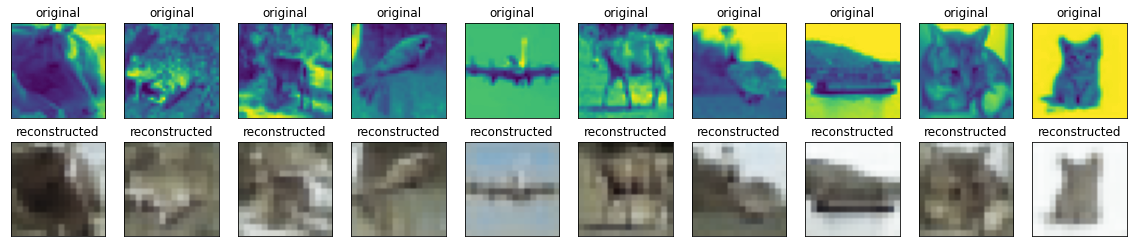

In [ ]:
plot_OriginalVsPredicted_Testset(test_img,output)

Here the model does not predict the colors in an image as accurately as compared to when it predicts the chrominance.  